In [33]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### EY analysis for the location in Golden



In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pvcircuit as pvc
from pvcircuit.PlotWithControls import PlotsWithControls
import ipywidgets as widgets
from scipy import constants
from scipy.optimize import curve_fit, fsolve
from scipy.special import erfc

from IPython import display

from pvcircuit.physics_helpers import fit_sandia_simple
from pvlib.pvsystem import singlediode

import os
import sys

from glob import glob
from datetime import datetime
import time
from tqdm.notebook import trange
import timeit

# set path for NREL meteorological package and import
sys.path.append("../../NREL_Meteorological")
from environmental import Spectra, Meteorological, sync
import warnings
from scipy.optimize import OptimizeWarning

Helpers


In [35]:
warnings.simplefilter("ignore", OptimizeWarning)


In [36]:
def wavelength_to_photonenergy(wavelength):
    return constants.h * constants.c / (wavelength * 1e-9) / constants.e


def photonenergy_to_wavelength(photonenergy):
    return constants.h * constants.c / (photonenergy * 1e-9) / constants.e


def _normalize(eqe: pd.DataFrame) -> pd.DataFrame:
    eqe_min = np.nanmin(eqe)
    eqe_max = np.nanmax(eqe)
    return (eqe - eqe_min) / (eqe_max - eqe_min)


def _eq_solve_Eg(Eg, *data):
    x, y = data
    return np.trapz(x * y, x) / np.trapz(y, x) - Eg


def _gaussian(x, a, x0, sigma):
    return 1 * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


def calc_Eg_Rau(eqe, fit_gaussian=True):
    # using [1] U. Rau, B. Blank, T. C. M. Müller, and T. Kirchartz,
    # “Efficiency Potential of Photovoltaic Materials and Devices Unveiled by Detailed-Balance Analysis,”
    # Phys. Rev. Applied, vol. 7, no. 4, p. 044016, Apr. 2017, doi: 10.1103/PhysRevApplied.7.044016.
    # extended by gaussian fit

    # Define the Gaussian function
    wavelength = eqe.index.values
    y = eqe.values
    x = wavelength_to_photonenergy(wavelength)

    # convert wavelength to photon energy
    y_grad = np.abs(np.gradient(y))
    # y_grad = np.abs(np.diff(y.values, prepend=np.nan))
    # y_grad = y.diff().abs().values

    # filter tail to avoid eqe dips at end/beginning of measurement
    y_grad = y_grad[(x < (x.max() + x.min())/2)]
    y = y[(x < (x.max() + x.min())/2)]
    x = x[(x < (x.max() + x.min())/2)]
    # normalize data
    y_grad = _normalize(y_grad)
    # get the index of the maximum
    y_diff_max_idx = np.nanargmax(y_grad)
    # get the max coordinates
    x_diff_max = x[y_diff_max_idx]
    y_diff_max = y_grad[y_diff_max_idx]

    # define lower threshold
    p_ab = np.exp(-2) * y_diff_max
    thres = 0.5
    # p_ab = thres * y_diff_max
    # find the index of the low-energy side where P(a) is max(P(Eg)/2)
    a_cond = np.where((y_grad < p_ab) & (x < x_diff_max))[0]
    if len(a_cond > 0):
        a_idx = np.nanmin(a_cond)
    else:
        a_idx = len(x) - 1
    a = x[a_idx]
    p_a = y_grad[a_idx]
    # find the index of the high-energy side where P(b) is max(P(Eg)/2)
    b_idx = np.nanmax(np.where((y_grad < p_ab) & (x > x_diff_max))[0])
    b = x[b_idx]
    p_b = y_grad[b_idx]

    x_target = x[a_idx : b_idx - 1 : -1]
    y_target = y_grad[a_idx : b_idx - 1 : -1]

    if fit_gaussian:

        # initial guesses from weighted arithmetic mean and weighted sample sigma
        mean = sum(x_target * y_target) / sum(y_target)
        sigma = np.sqrt(sum(y_target * (x_target - mean) ** 2) / sum(y_target))

        fit_res = curve_fit(
            _gaussian,
            x_target,
            y_target,
            p0=[max(y_target), mean, sigma],
        )
        x_fit = np.linspace(x[b_idx], x[a_idx], 100)
        y_fit = _gaussian(x_fit, *fit_res[0])

        # fig,ax = plt.subplots(1)
        # ax.plot(x, y_grad,'.')
        # ax.plot(x_fit, y_fit)
        # ax.plot(x_target, y_target, ".r")
        # ax.plot(x_diff_max, y_diff_max, "r*")
        # ax.plot(a, p_a, "g*")
        # ax.plot(b, p_b, "b*")
        # plt.plot(x_fit - fit_res[0][1], y_fit)
        # plt.plot(x_fit, y_fit)
        # ax.set_xlim(1.1, 1.8)
        # ax.set_ylabel(r"$\frac{{\mathrm{d}}EQE}{{\mathrm{d}}E_{\nu}}$")
        # ax.set_xlabel(r"Photon energy $E_{\nu}$ [eV]")

        x_fit = x_fit[y_fit >= thres * y_fit.max()]
        y_fit = y_fit[y_fit >= thres * y_fit.max()]
        sigma = fit_res[0][2]

    else:
        fit_res = [None]
        x_fit = x_target
        y_fit = y_target
        sigma = None

    res = fsolve(_eq_solve_Eg, 1.0, args=(x_fit, y_fit))
    bandgap = res[0]
    return bandgap, sigma


def si_eg_shift(temperature, bandgap_25):
    p = [-6.47214956e-04, 1.01632828e00]
    return (p[0] * temperature + p[1]) * bandgap_25


def si_sigma_shift(temperature, sigma_25):
    p = [0.00959188, 0.76558903]
    return (p[0] * temperature + p[1])*sigma_25


def psc_eg_shift(temperature, bandgap_25):
    t_split = 32
    p = [2.59551019e-04, 9.91138163e-01]
    res = np.zeros_like(temperature)

    t_filter = temperature > t_split
    res[t_filter] = p[0] * temperature[t_filter] + p[1]
    res[~t_filter] = p[0] * t_split + p[1]
    res = pd.Series(res, index = temperature.index)
    return res * bandgap_25


def psc_sigma_shift(temperature, sigma_25):
    p = [0.00358866, 0.90074156]
    return (p[0] * temperature + p[1])*sigma_25

def intergrate_eqe(eqe):
    path_to_am15_spectra = os.path.join(os.path.dirname(os.getcwd()), "data","ASTMG173.csv")  # Data files here
    # spectra = pd.read_csv(path_to_am15_spectra, header=[*range(0,3)])
    spectra_full = pd.read_csv(path_to_am15_spectra, header=[2])
    spectra_full.set_index(spectra_full.columns[0], inplace=True)

    spectra = spectra_full.reindex(eqe.index)
    if spectra.isnull().any(axis=1).any():
        spectra = spectra.reindex(index=si_eqe.index).interpolate(method="index")

    # jsc = (
    #     eqe.apply(lambda x: np.trapz(y=x * spectra["global"] / qe._wavelength_to_photonenergy(eqe.index), x=eqe.index)) / 10
    # )
    jsc = np.trapz(y=eqe.values * spectra["global"] / wavelength_to_photonenergy(eqe.index), x=eqe.index) / 10
    return jsc
    si_fit = np.polyfit(temperature_silicon, jsc[1:], 1)

    temps = np.linspace(min(temperature_silicon), max(temperature_silicon), 50)
    jsc_fit = np.polyval(si_fit, temps)

    fig, ax = plt.subplots(1)
    ax.plot(temperature_silicon, jsc[1:], "*", temps, jsc_fit)
    
def shift_eqe(eqe_ref, bandgap_25, sigma_25, bandgaps, sigmas, spectra):

    eqe = eqe_ref.values
    lam = eqe_ref.index.values
    Ey = constants.h * constants.c / (lam * 1e-9) / constants.e  # [eV]
    
    abs = 1 / 2 * erfc((bandgap_25 - Ey) / (sigma_25 * np.sqrt(2)))

    lam_eqe_saturation_idx = np.argmax(eqe * lam)
    eqe_saturation = eqe[lam_eqe_saturation_idx]
    lam_eqe_saturation = lam[lam_eqe_saturation_idx]


    jscs = []
    # fig,ax = plt.subplots()
    for i, col in enumerate(bandgaps):
        # print(qe_data.temperature)
        spec = spectra.iloc[i][lam]
        bandgap = bandgaps[i]
        sigma = sigmas[i]
        abs = 1 / 2 * erfc((bandgap - Ey) / (sigma * np.sqrt(2))) * eqe_saturation
        eqe_filter = lam > photonenergy_to_wavelength(bandgap + 2*sigma)
        eqe_new = np.concatenate([eqe[~eqe_filter],abs[eqe_filter]])
        # ax.plot(eqe_new)
        jscs.append(np.trapz(y = eqe_new * spec / wavelength_to_photonenergy(spec.index), x = spec.index) / 10)

    return jscs



Some notebook settings

In [37]:
t_elaps = None
t_elapsMP = None

squeeze_day_to_one_day = True # squeezes the meteo data into one day to allow plot comparison in one day
results = None

Load the meteorological data

In [38]:
def get_meteo(date_start, date_end, resampler):
    
    # date_start = datetime(2022, 6, 15, 0, 0, 0)  # sunny day
    # date_end = date_start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    meteo_data = Meteorological.get_midc_environmental(date_start, date_end)
    spectra_class = Spectra.get_srrl_wiser_global_track(date_start, date_end)

    # resample
    spectra_resampled = spectra_class.spectra.resample(resampler).median()
    meteo_resampled = meteo_data.data.resample(resampler).median()

    spectra_sync, meteo_sync = sync(spectra_resampled, meteo_resampled)

    # remove nan
    nan_filter = spectra_sync.isna().any(axis=1) | meteo_sync.isna().any(axis=1)
    spectra_sync = spectra_sync[~nan_filter]
    meteo_sync = meteo_sync[~nan_filter]

    # if squeeze_days_to_one_day:
    #     meteo_data.data.index = meteo_data.data.index.map(lambda dt: dt.replace(day=1))
    
    # import TMY data of meteo_location
    meteo_location = pvc.Meteo(
        wavelength=spectra_sync.columns,
        spectra=spectra_sync,
        ambient_temperature=meteo_sync["Deck Dry Bulb Temp [deg C]"],
        wind=meteo_sync["Avg Wind Speed @ 19ft [m/s]"],
        daytime=spectra_sync.index,
    )
    return meteo_location


Hard code scenarios for cell data

In [39]:
def get_jv_params(fp_psk_jv, fp_si_jv):
    path = os.path.join(os.path.dirname(os.getcwd()), "data")  # Data files here

    psk_data = pd.read_csv(os.path.join(path, fp_psk_jv))
    A = 0.112  # [cm^2]
    TC = 25  # [degC]

    # Measured terminal voltage.
    voltage = psk_data["v"].to_numpy(np.double)  # [V]
    # Measured terminal current.
    current = psk_data["i"].to_numpy(np.double) / 1000 * A  # [A]

    sort_id = np.argsort(voltage)

    voltage = voltage[sort_id]
    current = current[sort_id]

    voc_guess_idx = np.where(current >= 0)[0][-1]
    voc_guess_idx
    voltage = voltage[: voc_guess_idx + 2]
    current = current[: voc_guess_idx + 2]

    # fit iv
    # (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    psc_params = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
        voltage, current
    )
    ilim = 0.6
    while psc_params[2] < 0:
        ilim -=0.01        
        # fit iv
        psc_params = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
            voltage, current, ilim=ilim
        )
        
        
    si_data = pd.read_csv(os.path.join(path, fp_si_jv))
    # Measured terminal voltage.
    voltage = si_data["v"].to_numpy(np.double)  # [V]
    # Measured terminal current.
    current = si_data["i"].to_numpy(np.double) / 1000 * A  # [A]

    sort_id = np.argsort(voltage)

    voltage = voltage[sort_id]
    current = current[sort_id]

    voc_guess_idx = np.where(current >= 0)[0][-1]
    voc_guess_idx
    voltage = voltage[: voc_guess_idx + 2]
    current = current[: voc_guess_idx + 2]

    # fit iv
    si_params = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
        voltage, current
    )
    ilim = 0.6
    while si_params[2] < 0:
        ilim -=0.01        
        # fit iv
        si_params = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
            voltage, current, ilim=ilim
        )
        
    return psc_params, si_params

In [40]:
def get_tandem_eqe(fp_psk_eqe, fp_psk_trans, fp_si_eqe, psc_params, si_params):
    
    # get the Silicon paramters
    (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    (si_isc,si_io, si_rs, si_rsh, si_nNsVth) = si_params
    
    jo_scale = 1000
    A = 0.112  # [cm^2]
    TC = 25  # [degC]
    
    reader_settings = {"index_col": 0, "usecols": [0, 1]}
    df_psk_eqe = pd.read_excel(fp_psk_eqe, **reader_settings).dropna().squeeze("columns")
    df_psk_trans = pd.read_csv(fp_psk_trans, **reader_settings).dropna().squeeze("columns")
    df_si_eqe = pd.read_excel(fp_si_eqe, **reader_settings).dropna().squeeze("columns")

    df_psk_trans = None
    if df_psk_trans is None:
        df_psk_trans = 1 - _normalize(df_psk_eqe)
        
    # in case values are percentages
    if any(df_psk_eqe.values > 1):
        df_psk_eqe = df_psk_eqe.div(100)
    if any(df_psk_trans.values > 1):
        df_psk_trans = df_psk_trans.div(100)
    if any(df_si_eqe.values > 1):
        df_si_eqe = df_si_eqe.div(100)

    # # round in case wavelength has many floating points
    df_psk_eqe.index = np.round(df_psk_eqe.index.astype(np.double), 1)
    df_psk_trans.index = np.round(df_psk_trans.index.astype(np.double), 1)
    df_si_eqe.index = np.round(df_si_eqe.index.astype(np.double), 1)

    # integrate the EQE and compare the Jsc with the Jsc form the IV data. Assumption here is that the Jsc from IV measurement is the true value and EQE needs to be scaled
    eqe_scaler = psc_isc / A * 1e3 / intergrate_eqe(df_psk_eqe)
    df_psk_eqe = df_psk_eqe * eqe_scaler

    eqe_scaler = si_isc / A * 1e3 / intergrate_eqe(df_si_eqe)
    df_si_eqe = df_si_eqe * eqe_scaler

    # interpolate with eqe's superseding transmission wavelengths
    comb_lam = df_psk_eqe.index.union(df_si_eqe.index)
    df_psk_eqe_interp = df_psk_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
    df_psk_trans_interp = df_psk_trans.reindex(index=comb_lam).interpolate(method="index")
    df_si_eqe_interp = df_si_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
    

    df_si_eqe_filtered = df_psk_trans_interp * df_si_eqe_interp

    # get the bandgap to cut-off eqe of bottom cell where eqe of the top cell is weak
    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
    lam_cut_psc = photonenergy_to_wavelength(eg_psc + 2 * sigma_psc)

    df_si_eqe_filtered[df_psk_eqe_interp.index <= lam_cut_psc] = 0

    # commbine Psk and filter EQE
    df_tandem_eqe = pd.concat([df_psk_eqe_interp, df_si_eqe_filtered], axis=1)
    df_tandem_eqe.columns = ["Psk", "Si"]
    
    
    return df_tandem_eqe, df_si_eqe_interp


In [41]:
def match_eqe_spectra(df_tandem_eqe, spectra_sync):
    spectra_sync = spectra_sync.reindex(df_tandem_eqe.index,axis=1)
    spec_filter = ~spectra_sync.isna().all()
    spectra_sync = spectra_sync.iloc[:,spec_filter.values]
    df_tandem_eqe = df_tandem_eqe[spec_filter]
    return df_tandem_eqe, spectra_sync

In [42]:
def get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si):

    (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    (si_isc,si_io, si_rs, si_rsh, si_nNsVth) = si_params


    jo_scale = 1000
    A = 0.112  # [cm^2]
    TC = 25  # [degC]

    psc_jsc = psc_isc / A  # [A/cm^2]
    psc_jo = psc_io / A
    psc_n = psc_nNsVth / pvc.junction.Vth(TC)
    psc_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_psc)
    psc_joratio = jo_scale * psc_jo / (psc_jdb * jo_scale) ** (1.0 / psc_n)

    psc_rser = psc_rs * A
    psc_gsh = 1 / (psc_rsh * A)

    si_jsc = si_isc / A  # [A/cm^2]
    si_jo = si_io / A
    si_n = si_nNsVth / pvc.junction.Vth(TC)
    si_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_si)
    si_joratio = jo_scale * si_jo / (si_jdb * jo_scale) ** (1.0 / si_n)
    
    si_jsc = intergrate_eqe(df_si_eqe_filtered) / 1e3
    

    si_rser = si_rs * A
    si_gsh = 1 / (si_rsh * A)

    dev3T = pvc.Tandem3T()
    dev3T.set(name="PskSidev3T", Rz=1e-1)
    dev3T.top.set(Eg=eg_psc, J0ratio=[psc_joratio], Jext=psc_jsc, Gsh=psc_gsh, Rser=psc_rser, n=[psc_n])
    dev3T.bot.set(Eg=eg_si, J0ratio=[si_joratio], Jext=si_jsc, Gsh=si_gsh, Rser=si_rser, n=[si_n])
    return dev3T

In [43]:
def run_single_core(model, meteo_location):
    iref = 1  # global
    ncells = 60

    operlist = pvc.EY.VMlist(2)
    operlist.remove("VM11")
    num = len(operlist)
    ratio = [0] * num
    sEY = [0] * num
    rEY = [0] * num
    sEYeff = [0] * num
    rEYeff = [0] * num
    sSTCeff = [0] * num
    rSTCeff = [0] * num
    sloss = [0] * num
    rloss = [0] * num

    t_start = time.perf_counter()
    for i, oper in enumerate(operlist):
        model.bot.set(pn=1)  # s-type
        bot, top, ratio[i], type3T = pvc.EY.cellmodeldesc(model, oper)
        sloss[i] = pvc.EY.VMloss(type3T, bot, top, ncells)
        # sSTCeff[i] = meteo_location.cellSTCeff(model, oper)
        sEY[i], sEYeff[i] = meteo_location.cellEYeff(model, oper)

        if oper in ["MPP", "CM"]:
            rEY[i], rEYeff[i] = sEY[i], sEYeff[i]

        else:
            model.bot.set(pn=-1)  # r-type
            bot, top, ratio[i], type3T = pvc.EY.cellmodeldesc(model, oper)
            rloss[i] = pvc.EY.VMloss(type3T, bot, top, ncells)
            # rSTCeff[i] = meteo_location.cellSTCeff(model, oper)
            rEY[i], rEYeff[i] = meteo_location.cellEYeff(model, oper)
    t_elaps = time.perf_counter() - t_start
    return sEY, rEY, sEYeff, rEYeff, sSTCeff, rSTCeff, sloss, rloss, ratio, t_elaps


In [44]:
def run_multi_core(model, meteo_location):

    iref = 1  # global
    ncells = 60
    model = dev3T  # pointer?

    operlist = pvc.EY.VMlist(2)
    operlist.remove("VM11")
    num = len(operlist)
    ratio = [0] * num
    sEYeff_MP = [0] * num
    rEYeff_MP = [0] * num
    sEY_MP = [0] * num
    rEY_MP = [0] * num
    sSTCeff = [0] * num
    rSTCeff = [0] * num
    sloss = [0] * num
    rloss = [0] * num

    t_start = time.perf_counter()
    for idx, oper in enumerate(operlist):
        # for idx in trange(len(operlist)):
        oper = operlist[idx]
        model.bot.set(pn=1)  # s-type
        bot, top, ratio[idx], type3T = pvc.EY.cellmodeldesc(model, oper)
        sSTCeff[idx] = meteo_location.cellSTCeff(model, oper)

        model.bot.set(pn=-1)  # r-type
        bot, top, ratio[idx], type3T = pvc.EY.cellmodeldesc(model, oper)
        rSTCeff[idx] = meteo_location.cellSTCeff(model, oper)

    for idx, oper in enumerate(operlist):
        # for idx in trange(len(operlist)):
        oper = operlist[idx]
        model.bot.set(pn=1)  # s-type
        bot, top, ratio[idx], type3T = pvc.EY.cellmodeldesc(model, oper)
        sloss[idx] = pvc.EY.VMloss(type3T, bot, top, ncells)
        sEY_MP[idx], sEYeff_MP[idx] = meteo_location.cellEYeffMP(model, oper)

        if oper in ["MPP", "CM"]:
            rEY_MP[idx], rEYeff_MP[idx] = sEY_MP[idx], sEYeff_MP[idx]

        else:
            model.bot.set(pn=-1)  # r-type
            bot, top, ratio[idx], type3T = pvc.EY.cellmodeldesc(model, oper)
            rloss[idx] = pvc.EY.VMloss(type3T, bot, top, ncells)
            rEY_MP[idx], rEYeff_MP[idx] = meteo_location.cellEYeffMP(model, oper)
    t_elapsMP = time.perf_counter() - t_start
    return sEY_MP, rEY_MP, sEYeff_MP, rEYeff_MP, sSTCeff, rSTCeff, sloss, rloss, ratio, t_elapsMP


In [45]:
# import EQE of Psk and Tandem
# Transmittance data
# Pvsk_1.53eV_Qi_3-22_tr.csv
# Pvsk_1.60eV_Qi_3-22_tr.csv
# Pvsk_1.63eV_Qi_3-22_tr.csv
# Pvsk_1.70eV_Qi_3-22_tr.csv

# PSC EQE data
# Pvsk_1.25eV_QE.xlsx
# Pvsk_1.63MA-free_QE.xlsx
# Pvsk_1.68eV_QE.xlsx
# Pvsk_1.70MA-free_QE.xlsx
# Pvsk_1.75MA-free_QE.xlsx
# Pvsk_1.80MA-free_QE.xlsx
path = os.path.join(os.path.dirname(os.getcwd()), "data")  # Data files here

datalist = glob(path + "**" + os.path.sep +"*")
# print(*(f"{i:>2} --> {os.path.basename(x)}" for i, x in enumerate(datalist)), sep="\n")

fp_psk_eqe = {
    1.25 : [file for file in datalist if "1.25" in file and "_QE" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_QE" in file][0],
    1.68 : [file for file in datalist if "1.68" in file and "_QE" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_QE" in file][0],
    1.75 : [file for file in datalist if "1.75" in file and "_QE" in file][0],
    1.80 : [file for file in datalist if "1.80" in file and "_QE" in file][0]
}

fp_psk_trans = {
    1.25 : [file for file in datalist if "1.53" in file and "_tr" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.68 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.75 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.80 : [file for file in datalist if "1.70" in file and "_tr" in file][0]
}

fp_psk_jv = {
    1.25 : [file for file in datalist if "1.25" in file and "_JV" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_JV" in file][0],
    1.68 : [file for file in datalist if "1.68" in file and "_JV" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_JV" in file][0],
    1.75 : [file for file in datalist if "1.75" in file and "_JV" in file][0],
    1.80 : [file for file in datalist if "1.80" in file and "_JV" in file][0]
}


# file_psk_trans = "Pvsk0111D_1.7sb_tr.csv"
fp_si_eqe = [file for file in datalist if "Si_101_E1_005_14_2B_postITO_QE.xlsx" in file][0] 
fp_si_jv = [file for file in datalist if "Si_101_E1_005_14_2B_postITO_JV.csv" in file][0]




In [46]:
date_start = [datetime(2022,6,8, 0, 0, 0)]  # sunny day
date_start = [datetime(2022,5,31,8,19,0)]  # sunny day
# days = np.arange() + 1 # always start with 1
days = [1]
resamplers = ["1T"]
Rz_list = [0]

batches = [[date, day, resampler] for date in date_start for day in days for resampler in resamplers]
# for i in trange(len(batches), desc="Batch", colour="blue"):
#     date, day, resampler = batches[i]
#     date_start, day, resampler = batches[i]

#     date_end = date_start + pd.Timedelta(days=day) - pd.Timedelta(seconds=1)
#     for Eg in fp_psk_eqe.keys():
#         print(f"start {date_start} to {date_end} - Eg = {Eg}")
    

loading environmental from internal from 2022-05-31 08:19:00 to 2022-05-31 08:19:00
loading SRRL WISER global tracked from 2022-05-31 08:19:00 to 2022-05-31 08:19:00


array([[30.75984436,  6.20371371]])

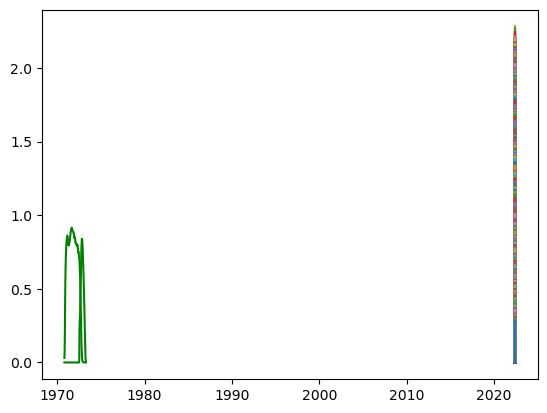

In [47]:
Eg = list(fp_psk_eqe.keys())[0]

psc_params, si_params = get_jv_params(fp_psk_jv[Eg], fp_si_jv)
df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[Eg], fp_psk_trans[Eg], fp_si_eqe, psc_params, si_params)
df_psk_eqe_interp = df_tandem_eqe.iloc[:,0]
df_si_eqe_filtered = df_tandem_eqe.iloc[:,1]

eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)

eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)

eqe = df_tandem_eqe.to_numpy(dtype=np.float64, copy=True)
lam = df_tandem_eqe.index.to_numpy(dtype=np.float64, copy=True)

EQE2J = pvc.EQE(eqe, lam, "Psk-Si")  # EQE class
EQE2J.sjuncs = ["Psk", "Si"]  # rename junctions

# ax,rax = EQE2J.plot()
fig,ax = plt.subplots()
ax.plot(df_tandem_eqe,"g")

meteo_location = get_meteo(date_start[0], date_start[0], resamplers[0])
ax.plot(meteo_location.spectra)
EQE2J.Jint()


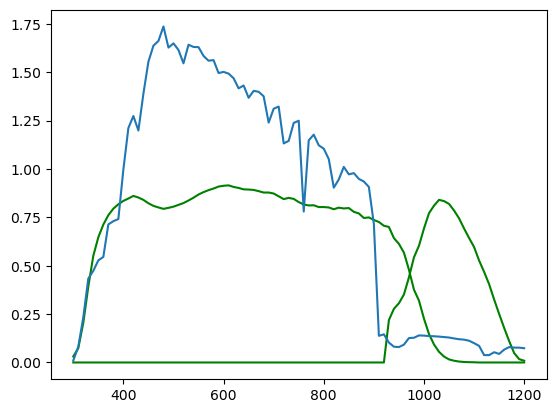

In [50]:
fig,ax = plt.subplots()
ax.plot(df_tandem_eqe,"g")
ax.plot(meteo_location.spectra.loc[date_start])


In [49]:
for i in trange(len(batches), desc="Batch", colour="blue"):
    date_start, day, resampler = batches[i]

    date_end = date_start# + pd.Timedelta(days=day) - pd.Timedelta(seconds=1)
    # date_end = datetime(2022, 7, 1, 0, 0, 0) - pd.Timedelta(seconds=1)
    spectra_label = "get_srrl_wiser_global_track"

    meteo_location = get_meteo(date_start, date_end, resampler)

    for Eg in fp_psk_eqe.keys():
        
        for Rz in Rz_list:

            psc_params, si_params = get_jv_params(fp_psk_jv[Eg], fp_si_jv)
            df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[Eg], fp_psk_trans[Eg], fp_si_eqe, psc_params, si_params)
            df_tandem_eqe, meteo_location.spectra = match_eqe_spectra(df_tandem_eqe, meteo_location.spectra)
            df_psk_eqe_interp = df_tandem_eqe.iloc[:,0]
            df_si_eqe_filtered = df_tandem_eqe.iloc[:,1]

            eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
            egs_si = si_eg_shift(meteo_location.TempCell, eg_si)
            sigmas_si = si_sigma_shift(meteo_location.TempCell, sigma_si)

            eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
            egs_psc = psc_eg_shift(meteo_location.TempCell, eg_psc)
            sigmas_psc = psc_sigma_shift(meteo_location.TempCell, sigma_psc)

            si_jscs = shift_eqe(df_si_eqe_filtered, eg_si, sigma_si, egs_si, sigmas_si, meteo_location.spectra)
            psc_jscs = shift_eqe(df_psk_eqe_interp, eg_psc, sigma_psc, egs_psc, sigmas_psc, meteo_location.spectra)

            eqe = df_tandem_eqe.to_numpy(dtype=np.float64, copy=True)
            lam = df_tandem_eqe.index.to_numpy(dtype=np.float64, copy=True)

            EQE2J = pvc.EQE(eqe, lam, "Psk-Si")  # EQE class
            EQE2J.sjuncs = ["Psk", "Si"]  # rename junctions

            meteo_location.cellcurrents(EQE2J, STC=True)

            meteo_location.Egs = np.array([egs_psc.values, egs_si.values]).T
            meteo_location.Jscs = np.array([psc_jscs, si_jscs]).T / 1e3

            dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
            dev3T.top.set(Rser=Rz)
            dev2T = pvc.Multi2T.from_3T(dev3T)

            sEY, rEY, sEYeff, rEYeff, sSTCeff, rSTCeff, sloss, rloss, ratio, t_elaps = run_single_core(dev3T, meteo_location)
            # sEY_MP, rEY_MP, sEYeff_MP, rEYeff_MP, sSTCeff, rSTCeff, sloss, rloss, ratio, t_elapsMP = run_multi_core(dev3T, meteo_location)

            df = pd.DataFrame()
            df["ratio"] = ratio
            df["Eg"] = Eg
            # df["sEY"] = sEY_MP
            # df["rEY"] = rEY_MP
            # df["sEYeff"] = sEYeff_MP
            # df["rEYeff"] = rEYeff_MP
            df["sSTCeff"] = sSTCeff
            df["rSTCeff"] = rSTCeff
            df["sloss"] = sloss
            df["rloss"] = rloss
            df["date_start"] = date_start
            df["date_end"] = date_end
            df["duration"] = t_elaps
            df["durationMP"] = t_elapsMP
            df["times"] = meteo_location.daytime.size
            df["resampler"] = resampler
            df["spectra"] = spectra_label

            if results is None:
                results = df
            else:
                results = pd.concat([results, df])
            
            # display.clear_output()


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

loading environmental from internal from 2022-05-31 08:19:00 to 2022-05-31 08:19:00
loading SRRL WISER global tracked from 2022-05-31 08:19:00 to 2022-05-31 08:19:00


  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
egs = np.array([model.top.Eg for model in meteo_location.models])
# [model.oper for model in meteo_location.models]
operation_modes = np.array(meteo_location.operation_modes)

tandem_type = np.array(meteo_location.tandem_types)
Rzs = np.array([model.top.Rser for model in meteo_location.models])

/var/folders/9g/q1s4db0s37z6gkqp7c8nw7b15yw74j/T/ipykernel_90811/115631984.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees


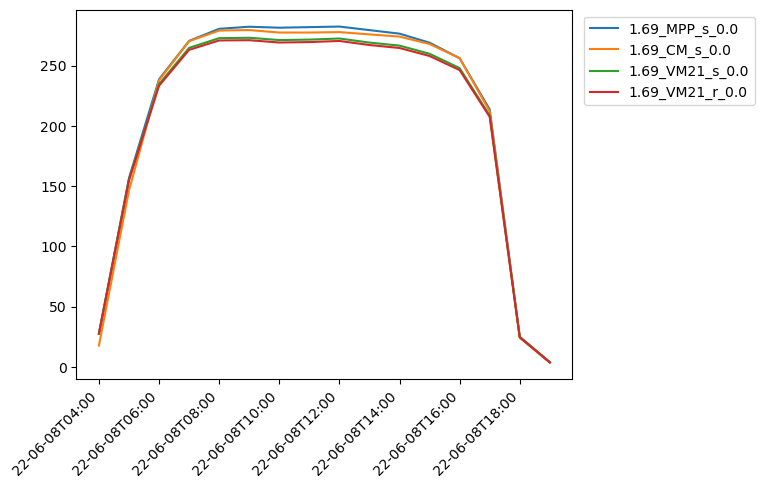

In [ ]:
chose = 0
# eg_filter = (egs == np.unique(egs)[chose]) & (operation_modes == "MPP") & (tandem_type == "s")
eg_filter = egs == np.unique(egs)[chose]
fig, ax = plt.subplots(1)
# ax.plot(meteo_location.inPower,meteo_location.outPower[:,eg_filter], "-")
ax.plot(meteo_location.daytime,meteo_location.outPower[:,eg_filter], "-")
leg = ax.legend([f"{eg:.2f}_{oper}_{type3T}_{Rz}" for eg,oper,type3T,Rz in list(zip(egs[eg_filter], operation_modes[eg_filter], tandem_type[eg_filter], Rzs))],loc="upper left", bbox_to_anchor=(1.01,1))
ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%dT%H:%M'))
fig.savefig(f"EY_jan_{np.unique(egs)[chose]:.2f}.png", bbox_extra_artists=(leg,), bbox_inches='tight')


/var/folders/9g/q1s4db0s37z6gkqp7c8nw7b15yw74j/T/ipykernel_90811/2674573251.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees


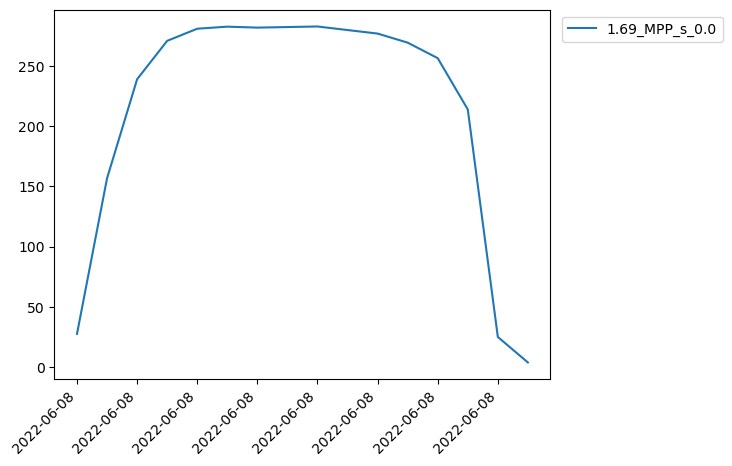

In [ ]:
# eg_filter = (egs == np.unique(egs)[chose]) & (operation_modes == "MPP") & (tandem_type == "s")
eg_filter = egs == np.unique(egs)[chose]
op_filter =  np.isin(operation_modes, ["MPP"])
type_filter =  np.isin(tandem_type, ["s"])

all_filter = eg_filter & op_filter & type_filter

fig, ax = plt.subplots(1)
# ax.plot(meteo_location.inPower,meteo_location.outPower[:,eg_filter], "-")
ax.plot(meteo_location.daytime,meteo_location.outPower[:,all_filter] , "-")
leg = ax.legend([f"{eg:.2f}_{oper}_{type3T}_{Rz}" for eg,oper,type3T,Rz in list(zip(egs[all_filter], operation_modes[all_filter], tandem_type[all_filter], Rzs[all_filter]))],loc="upper left", bbox_to_anchor=(1.01,1))
# ax.set_xticks(ax.get_xticks(),rotation=30)
# ax.set_xticklabels(ax.get_xticks(), rotation = 45)
# ax.set_xticklabels(ax.get_xticks(), rotation=45)  # Rotates X-Axis Ticks by 45-degrees
ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.savefig(f"RelEY_jan_{np.unique(egs)[chose]:.2f}.png", bbox_extra_artists=(leg,), bbox_inches='tight')

In [ ]:
chose

0

/var/folders/9g/q1s4db0s37z6gkqp7c8nw7b15yw74j/T/ipykernel_90811/2274159644.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees


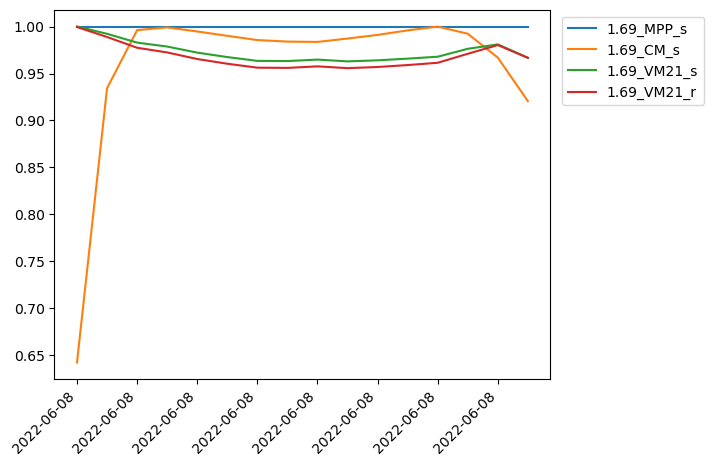

In [ ]:
# eg_filter = (egs == np.unique(egs)[chose]) & (operation_modes == "MPP") & (tandem_type == "s")
eg_filter = egs == np.unique(egs)[chose]
op_filter =  np.isin(operation_modes, ["MPP", "VM21", "CM"])
type_filter =  np.isin(tandem_type, ["s", "r"])
rzs_filter = Rzs == np.unique(Rzs)[chose]


all_filter = eg_filter & op_filter & type_filter & rzs_filter

eg_filter = egs == np.unique(egs)[chose]
op_filter =  np.isin(operation_modes, ["MPP"])
type_filter =  np.isin(tandem_type, ["s"])
rzs_filter = Rzs == np.unique(Rzs)[chose]

ref_filter = eg_filter & op_filter & type_filter & rzs_filter

fig, ax = plt.subplots(1)
# ax.plot(meteo_location.inPower,meteo_location.outPower[:,eg_filter], "-")
ax.plot(meteo_location.daytime,meteo_location.outPower[:,all_filter] / meteo_location.outPower[:,ref_filter], "-")
leg = ax.legend([f"{eg:.2f}_{oper}_{type3T}" for eg,oper,type3T in list(zip(egs[eg_filter], operation_modes[eg_filter], tandem_type[eg_filter]))],loc="upper left", bbox_to_anchor=(1.01,1))
# ax.set_xticks(ax.get_xticks(),rotation=30)
# ax.set_xticklabels(ax.get_xticks(), rotation = 45)
# ax.set_xticklabels(ax.get_xticks(), rotation=45)  # Rotates X-Axis Ticks by 45-degrees
ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# fig.savefig(f"RelEY_jan_{np.unique(egs)[chose]:.2f}.png", bbox_extra_artists=(leg,), bbox_inches='tight')

/var/folders/9g/q1s4db0s37z6gkqp7c8nw7b15yw74j/T/ipykernel_90811/1558962341.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees


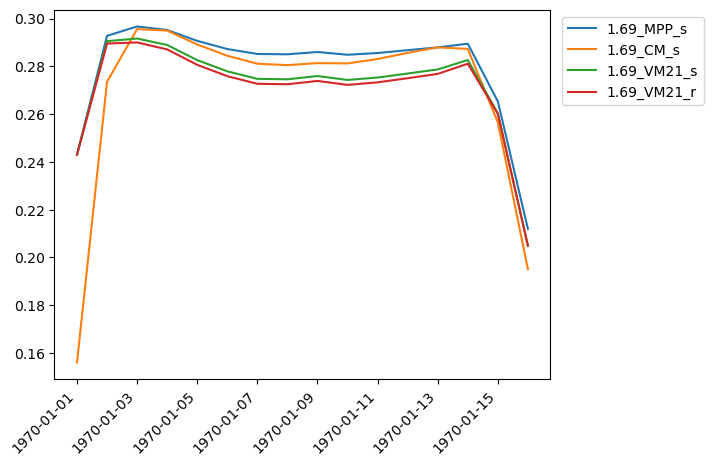

In [ ]:
# eg_filter = (egs == np.unique(egs)[chose]) & (operation_modes == "MPP") & (tandem_type == "s")
eg_filter = egs == np.unique(egs)[chose]
op_filter =  np.isin(operation_modes, ["MPP", "VM21", "CM"])
type_filter =  np.isin(tandem_type, ["s", "r"])

all_filter = eg_filter & op_filter & type_filter

eg_filter = egs == np.unique(egs)[chose]
op_filter =  np.isin(operation_modes, ["MPP"])
type_filter =  np.isin(tandem_type, ["s"])
ref_filter = eg_filter & op_filter & type_filter

fig, ax = plt.subplots(1)
# ax.plot(meteo_location.inPower,meteo_location.outPower[:,eg_filter], "-")
ax.plot(meteo_location.outPower[:,all_filter] / np.tile(meteo_location.inPower,(4,1)).T, "-")
leg = ax.legend([f"{eg:.2f}_{oper}_{type3T}" for eg,oper,type3T in list(zip(egs[eg_filter], operation_modes[eg_filter], tandem_type[eg_filter]))],loc="upper left", bbox_to_anchor=(1.01,1))
# ax.set_xticks(ax.get_xticks(),rotation=30)
# ax.set_xticklabels(ax.get_xticks(), rotation = 45)
# ax.set_xticklabels(ax.get_xticks(), rotation=45)  # Rotates X-Axis Ticks by 45-degrees
ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')  # Rotates X-Axis Ticks by 45-degrees
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# fig.savefig(f"RelEY_jan_{np.unique(egs)[chose]:.2f}.png", bbox_extra_artists=(leg,), bbox_inches='tight')

In [ ]:
# print(all(meteo_location.outPower-meteo_location.outPowerMP < 1e-6))
plt.figure()
plt.plot(meteo_location.inPower, meteo_location.outPowerMP / meteo_location.inPower, "*")
# plt.plot(meteo_location.Egs, "*")
plt.show()


AttributeError: 'Meteo' object has no attribute 'outPowerMP'

<Figure size 640x480 with 0 Axes>

KeyError: 'sEYeff'

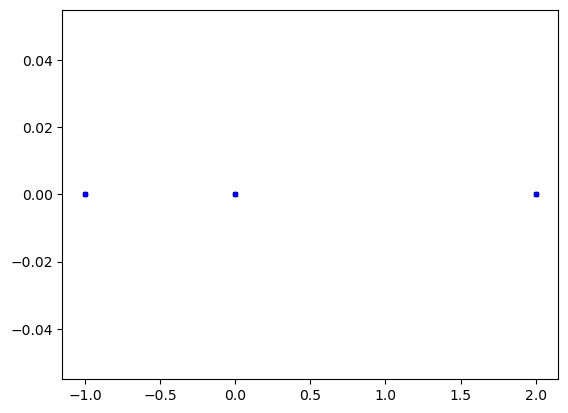

In [ ]:
fig, ax = plt.subplots()
ax.plot(df["ratio"], 100 * df["sSTCeff"], c="black", ms=3, lw=0, marker="s", label="s-type cell STC")
ax.plot(df["ratio"], 100 * df["rSTCeff"], c="blue", ms=3, lw=0, marker="o", label="r-type cell STC")
ax.plot(df["ratio"], 100 * df["sEYeff"] * df["sloss"], c="black", ms=10, lw=0, marker="s", label="s-type module(60cells) yield")
ax.plot(df["ratio"], 100 * df["rEYeff"] * df["rloss"], c="blue", ms=10, lw=0, marker="o", label="r-type module(60cells) yield")
ax.set_ylim(15, 45)
ax.set_ylabel("Efficiency (%)")
ax.set_xlabel("Voltage-Matching Ratio (m/n)")
ax.text(3, 16, "3T", ha="center")
ax.text(0, 20, "2T", ha="center", rotation="vertical")
ax.text(-1.0, 22, "4T", ha="center", rotation="vertical")
ax.legend()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = '4T'
labels[2] = '2T'
ax.set_xticklabels(labels)

In [ ]:
# cell = os.path.basename(fp_psk_eqe[Eg]).split("_")[1]
# fig.savefig(f"./{date_start:%Y-%m-%d}_{date_end:%Y-%m-%d}_meteo_location_{resampler}_{spectra_label}_{cell}.png")


In [ ]:
# json_settings = {"orient": "split"}
# # stats = pd.DataFrame(
# #     [
# #         {
# #             "date_start": results.date_start.apply(lambda x: x.strftime("%Y-%m-%d")),
# #             "date_end": results.date_start.apply(lambda x: x.strftime("%Y-%m-%d")),
# #             "duration": t_elaps,
# #             "durationMP": t_elapsMP,
# #             "times": meteo_location.daytime.size,
# #             "resampler": resampler,
# #         }
# #     ]
# # )

# stats = pd.concat([results.date_start.apply(lambda x: x.strftime("%Y-%m-%d")), results.date_end.apply(lambda x: x.strftime("%Y-%m-%d")),results.duration, results.durationMP, results.times, results.resampler],axis=1)


# if os.path.exists("./stats.json"):
#     old_stats = pd.read_json("./stats.json")
#     stats = pd.concat([old_stats, stats]).reset_index(drop=True)
#     stats.to_json("./stats.json")
# else:
#     stats.to_json("./stats.json")


In [ ]:
# stats = pd.read_json("./stats.json")
# fig, ax = plt.subplots()


# fit = np.polyfit(
#     np.log(stats["times"][~np.isnan(np.log(stats["duration"]))]), np.log(stats["duration"][~np.isnan(np.log(stats["duration"]))]), 1
# )

# fit_x = np.linspace(np.min(stats["times"]), np.max(stats["times"]), 50)
# fit_y = np.polyval(fit, fit_x)

# plt.plot(stats["times"], stats["duration"], "k*")
# plt.plot(stats["times"], stats["durationMP"], "r*")
# plt.plot(fit_x, fit_y, "--")
# stats["duration"] / stats["times"]
# # ax.set_xlim(left=1)
# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_xlabel("Number of time steps [-]")
# ax.set_ylabel("Simulation duration [s]")
# fit


In [ ]:
# stats
# fig, ax = plt.subplots()

# # fit = np.polyfit(np.log(stats["times"]), np.log(stats["duration"]), 1)
# fit = np.polyfit(stats["times"][~np.isnan(np.log(stats["duration"]))], stats["duration"][~np.isnan(np.log(stats["duration"]))], 1)


# fit_x = np.linspace(np.min(stats["times"]), np.max(stats["times"]), 50)
# # fit_y = np.polyval(fit, fit_x)
# # fit_y = np.exp(fit[1] + fit[0] * np.log(fit_x))
# fit_y = fit[1] + fit[0] * (fit_x)
# # fit_y_lin = fit[1] + fit[0] * fit_x
# # fit_y_lin = np.log(fit[1]) + fit_x**(fit[0])

# plt.plot(stats["times"], stats["duration"], "k*", label="Single processing")
# plt.plot(stats["times"], stats["durationMP"], "rs", label="Multi processing")
# plt.plot(fit_x, fit_y, "--")
# # plt.plot(fit_x, fit_y_lin, "--")
# stats["duration"] / stats["times"]
# # ax.set_xlim(left=1)
# # ax.set_xscale("log")
# # ax.set_yscale("log")
# ax.set_xlabel("Number of time steps [-]")
# ax.set_ylabel("Simulation duration [s]")

# leg = ax.legend()
# fit
